# Temporary sandbox notebook
Only for integrating DOS plot into bandplot experiments.

Done here so as not to mess up the main notebook.

When done and stable, integrate changes back into main development notebook.

# Setup

## Setup masci-tools path

In [1]:
# IMPORTANT: we need to import stuff from masci-tools folder.
# Since masci-tools is not installed as a module (yet), the notebook kernel
# needs to be started in the masci-tools folder.
# If that has not happened for some reason, then need to add the masci-tools
# manually to the sys path.
import os
import sys

cwd = os.getcwd()
path_mtools = cwd
dirname_mtools = "masci-tools"
# first try if we can get away without needing an absolute path
if dirname_mtools in path_mtools:
    while os.path.basename(path_mtools) != dirname_mtools:
        path_mtools = os.path.split(path_mtools)[0]
else:
    # okay, try with an absolute path
    path_mtools = "/home/johannes/Desktop/Studium/Kurse_RWTH/SiScLab/18W/repos/masci-tools"
    if not os.path.isdir(path_mtools):
        raise IOError(f"Could not find path to masci-tools. Please specify absolute path.")

# found masci-tools. add to syspath (for imports) and chdir.
if path_mtools not in sys.path:
    # add only once
    sys.path.append(path_mtools)

## Setup imports

In [2]:
# Jupyter, Python imports
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

#  python 3interactive figures in a live IPython notebook session
# if run from jupyter-notebook: MAGICmatplotlib nbagg
# if run from jupyter-lab: MAGICmatplotlib widget
%matplotlib widget

# studentproject18ws imports
import os
import logging
from studenproject18ws.hdf.reader import Reader
from studenproject18ws.hdf.recipes import Recipes
from studenproject18ws.plot.plot import Bandplot_matplotlib as Bandplot

## Read file, import data

- TODO: link with widget-based file-chooser

In [3]:
# # NO DOS file:
# filename = 'banddos.hdf'
# filename = 'banddos_4x4.hdf'
# filename = 'banddos_sodium.hdf'
# # 1 DOS file:
# filename = os.path.join('MoSe2', 'banddos_2spin.hdf')
filenames_dos = [os.path.join('MoSe2',"DOS.1")]

# # 2 DOS files:
filename = os.path.join('Co', 'banddos_Co.hdf')
filenames_dos = [os.path.join('Co', 'DOS.1'), os.path.join('Co', 'DOS.2')]

filepath = ['..', 'data', 'input', filename]
filepath = os.path.join(*filepath)
filepaths_dos = [['..', 'data', 'input', fd] for fd in filenames_dos]
filepaths_dos = [os.path.join(*fpd) for fpd in filepaths_dos]

data = None
extractor = Reader(filepath=filepath)
with extractor as h5file:
    data = extractor.read(recipe=Recipes.Bands)
    #
    # Note:
    # Inside the with statement (context manager),
    # all data attributes that are type h5py Dataset are available (in-file access)
    # When the statement is left,the HDF5 file gets closed and the datasets are closed.
    #
    # Use data outside the with-statement (in-memory access: all HDF5 datasets converted to numpy ndarrays):
    data.move_datasets_to_memory()

# Testing: compare DOS plotting methods without band plot

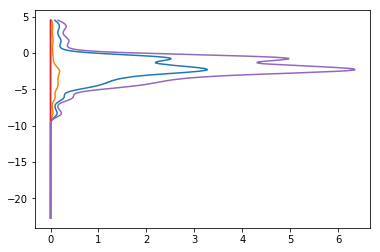

NameError: name 'bandplotter' is not defined

<Figure size 432x288 with 0 Axes>

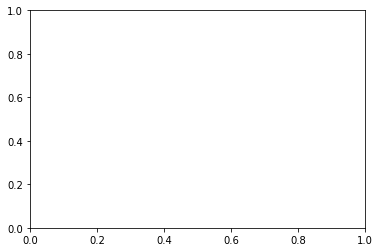

In [4]:
def plot_dos_old(ax_dos, filepath_dos):
    dos_data = np.genfromtxt(filepath_dos).T
    energy_dos = dos_data[0]
    totdos = dos_data[1]
    interst = dos_data[2]
    vac1 = dos_data[3]
    vac2 = dos_data[4]
    weights_atomgrps_dos = dos_data[5:]

#     ax_dos = fig.add_subplot(111)
    ax_dos.plot(totdos, energy_dos)
    ax_dos.plot(interst, energy_dos)

    #constant 0
    ax_dos.plot(vac1, energy_dos)
    ax_dos.plot(vac2, energy_dos)

    ax_dos.plot((sum(weights_atomgrps_dos)+interst), energy_dos)
#     plt.show()


# compare our plot_dos (OLD one as of 17.01.19), and masci-tool's plot_dos output.
fig, ax = plt.subplots(1)
plot_dos_old(ax, filepaths_dos[0])
plt.show()

plt.clf()
fig, ax = plt.subplots(1)
sel = data.simulate_gui_selection()
bandplotter.dos(filepaths_dos[0], sel.mask_groups, sel.mask_characters,
           select_groups=True, interstitial=True, all_characters=True,
               ax=ax)
plt.show()


from masci_tools.vis.plot_methods import plot_dos as plot_dos_masci
plot_dos_masci(filepaths_dos[0])



# Define Widgets

## Band plot

### Plot function

In [4]:
bandplotter = Bandplot(data)
        

### Define user input arguments

In [19]:
# bands = atom_group_keys = e.g. for banddos.hdf: dict_keys[(1,2,3,4,5)]
#                           Hm... should better convert to tuple back in reader?
def_groups = data.atoms_group_keys
select_groups = widgets.SelectMultiple(options=def_groups, 
                                   value=tuple(def_groups),
                                  description='Atom Groups',
                                  disabled=False)


def_characters = ['s', 'p', 'd', 'f']
# Characters = namedtuple('Characters', ['s', 'p', 'd', 'f'])
# characters = Characters(0,1,2,3)
select_characters = widgets.SelectMultiple(options=def_characters,
                                          value=tuple(def_characters),
                                          description='Band Character',
                                          disabled=False)

# number of bands can be large, so use a rangeslider instead of selectionslider
def_bands = [band for band in range(data.eigenvalues.shape[2])]
select_bands = widgets.IntRangeSlider(value=[def_bands[0]+1,def_bands[-1]+1], 
                                      min=def_bands[0]+1, max=def_bands[-1]+1, step=1,
                                     description='Bands',
                                     disabled=False, continuous_update=False,
                                     orientation='horizontal', readout=True,
                                     readout_format='d')

select_exponent = widgets.FloatSlider(
    value=1.0,
    min=0,
    max=4.0,
    step=0.01,
    description='Unfolding weight exponent',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f')

select_marker_size = widgets.FloatSlider(
    value=1.0,
    min=0,
    max=10.0,
    step=0.01,
    description='Marker size',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f')

select_compare_characters = widgets.Checkbox(
    value=False,
    description="Compare 2 characters (disabled)",
    disabled=True
)

# make compare_characters only available when 2 characters are selected
def on_character_selection_change(change):
    if len(change.new) == 2:
        select_compare_characters.disabled = False
        select_compare_characters.description = "Compare 2 characters (enabled)"
    else:
        select_compare_characters.disabled = True
        select_compare_characters.description = "Compare 2 characters (disabled)"
select_characters.observe(on_character_selection_change, names='value')

# when compare_characters is active, disable select_characters
def on_compare_character(change):
    select_characters.disabled = change.new
select_compare_characters.observe(on_compare_character, names='value')

## Try out the new DOS plot method interactively without band plot

In [24]:
spin = 0

fig_scale = 0.65
fig_ratio = [10,6]
fig, ax = plt.subplots(1, figsize=[fig_scale * el for el in fig_ratio])
plt.suptitle(f"DOS of {filenames_dos[spin]}")

# plt.clf()
# fig, ax = plt.subplots(1)
# sel = data.simulate_gui_selection()
# bandplotter.dos(filepaths_dos[0], sel.mask_groups, sel.mask_characters,
#            select_groups=True, interstitial=True, all_characters=True,
#                ax=ax)
# plt.show()

@interact(characters=select_characters, groups=select_groups, dos_groups_yesno=True, interstitial=True, all_characters=True)
def update_plot_dos_test(characters, groups, dos_groups_yesno, interstitial, all_characters):
    ax.clear
    bandplotter.dos(filepaths_dos[0], groups, characters,
           dos_groups_yesno, interstitial, all_characters,
               ax=ax)


FigureCanvasNbAgg()

interactive(children=(SelectMultiple(description='Band Character', index=(2,), options=('s', 'p', 'd', 'f'), v…

## Interact function

In [20]:
fig_scale = 0.65
fig_ratio = [10,6]
fig, (ax, ax_dos) = plt.subplots(1, 2, sharey=True, figsize=[fig_scale * el for el in fig_ratio])
plt.suptitle(f"BandStructure of {filename}")
fig.subplots_adjust(wspace=0)

plot_dos_old(ax_dos, filepaths_dos[0])


@interact(bands=select_bands, characters=select_characters, groups=select_groups, 
          unfolding_weight_exponent=select_exponent, marker_size=select_marker_size,
         compare_characters=select_compare_characters)
def update_plot(bands, characters, groups, 
                unfolding_weight_exponent, marker_size,
               compare_characters):
    ax.clear
#     bandplotter.setup(ax)
    
    # convert arguments to the expected format for code 181124
    bands_conved = range(bands[0]-1,bands[1])
    groups_conved = [el-1 for el in groups]
    characters_conved = [def_characters.index(el) for el in characters]

    # TODO: switch button for ignore_atoms_per_group
    ignore_atoms_per_group = True #default
    
    # convert arguments to the expected format for code 181212
    mask_characters = [el in characters for el in def_characters]
    mask_bands = [el in bands_conved for el in def_bands]
    mask_groups = [el in [el for el in groups] for el in def_groups]
    
    spins = [0]
    
    bandplotter.plot(mask_bands, mask_characters, mask_groups, spin, 
         unfolding_weight_exponent, compare_characters, ax, ignore_atoms_per_group, marker_size)

FigureCanvasNbAgg()

interactive(children=(IntRangeSlider(value=(1, 24), continuous_update=False, description='Bands', max=24, min=…

In [13]:
import ipyvolume as ipv
x, y, z = data.atoms_position.T
@interact(groups=select_groups)
def update_atoms_plot(groups):
    selected_atoms = []
    for group in groups:
        selected_atoms_group = np.where(data.atoms_group==group)
        for selected_atom_group in selected_atoms_group:
            selected_atoms.extend(selected_atom_group)
    
    ipv.figure()
    scatter = ipv.scatter(x,y,z, size=5, marker="sphere", selected=selected_atoms, size_selected=8)
    ipv.show()

    

interactive(children=(SelectMultiple(description='Atom Groups', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1…

In [29]:
bla = [False, True, False, True]
for i, val in enumerate(bla):
    print(f"{i}, {val}")
    
bla[1] == True

0, False
1, True
2, False
3, True


True